#  RNN With TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/alvaro/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TimeSeriesData():
    """
    Initialise the data and also send batches of the data back for f(x) = sin(x)
    """
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        
        self.x_data = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        """
        Given an np.array x_series, return the sin(x_series)
        """
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        # Grab a random starting point
        rand_start = np.random.rand(batch_size, 1)
                
        # Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps * self.resolution)) 
        
        # Create a batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
        
        # Create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        # Format for the RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_ts
        else:
            # batch and batch one step into the future
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)
    

In [3]:
ts_data = TimeSeriesData(250, 0, 10)

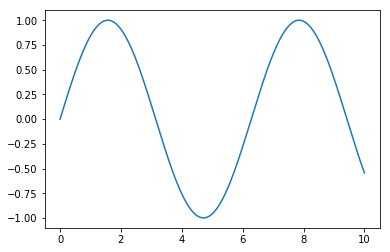

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true);

In [5]:
num_time_steps = 30

In [6]:
y1, y2, ts = ts_data.next_batch(batch_size=1, steps=num_time_steps, return_batch_ts=True)

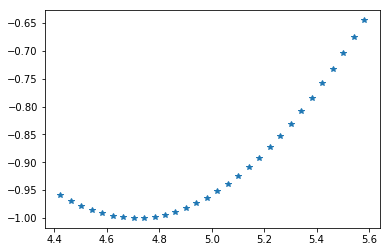

In [7]:
plt.plot(ts.flatten()[1:], y2.flatten(), '*');

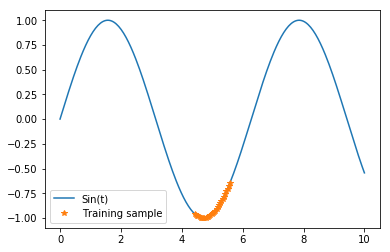

In [8]:
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Training sample')
plt.legend();

In [9]:
train_inst = np.linspace(5, 5 + ts_data.resolution * (num_time_steps + 1), num_time_steps + 1)

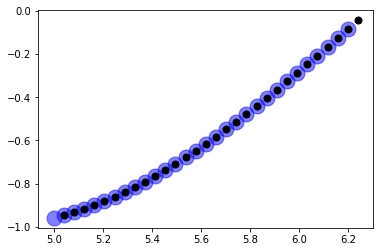

In [10]:
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='instance')
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), 'ko', markersize=7, label='target');

The challenge is: given the blue dots, can you predict the black dots? (Including the one outside)

## Create the Model

In [11]:
tf.reset_default_graph()

In [12]:
# Constants
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
num_train_iterations = 2000
batch_size = 1

In [13]:
# Placeholders
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

# RNN Cell
cell_unwrapped = tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu)

cell = tf.contrib.rnn.OutputProjectionWrapper(cell_unwrapped, output_size=num_outputs)

# Dynamic Unrolling of inputs
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


#Mean Square Error
loss = tf.reduce_mean(tf.square(outputs-y))

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [14]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)    

In [15]:
saver = tf.train.Saver()

In [16]:
# Session
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, '\tMSE: ', mse)
    
    saver.save(sess, './rnn_time_series_model_mysavedmodel')

0 	MSE:  0.12622759
100 	MSE:  0.052838575
200 	MSE:  0.013465474
300 	MSE:  0.02504642
400 	MSE:  0.004830397
500 	MSE:  0.013959351
600 	MSE:  0.00863311
700 	MSE:  0.0040634656
800 	MSE:  0.0002586154
900 	MSE:  0.0006207063
1000 	MSE:  0.00045556104
1100 	MSE:  0.00031087984
1200 	MSE:  5.2161187e-05
1300 	MSE:  6.34561e-05
1400 	MSE:  0.0001303971
1500 	MSE:  0.00023496644
1600 	MSE:  0.00024230473
1700 	MSE:  0.0003541295
1800 	MSE:  1.6991991e-05
1900 	MSE:  0.0004293774


## Prediction time

In [17]:
with tf.Session() as sess:
    
    saver.restore(sess, './rnn_time_series_model_mysavedmodel')
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_mysavedmodel


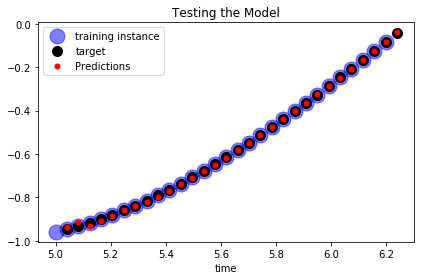

In [18]:
plt.title('Testing the Model')

# Training instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='training instance')

# Correct values (sin(x))
plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize=10, label='target')

# Models prediction
plt.plot(train_inst[1:], y_pred[0, :, 0], 'r.', markersize=10, label='Predictions')

plt.xlabel('time')
plt.legend()
plt.tight_layout();

## Generating a New Sequence

In [20]:
with tf.Session() as sess:
    
    saver.restore(sess, './rnn_time_series_model_mysavedmodel')
    
    # Seed Zeros
    zeros_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        
        X_batch = np.array(zeros_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        zeros_seq_seed.append(y_pred[0, -1, 0])
    

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_mysavedmodel


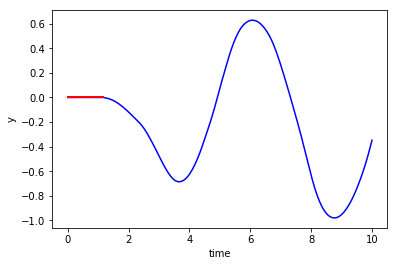

In [23]:
plt.plot(ts_data.x_data, zeros_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], zeros_seq_seed[:num_time_steps], 'r', linewidth=2)
plt.xlabel('time')
plt.ylabel('y');


In [32]:
with tf.Session() as sess:
    
    saver.restore(sess, './rnn_time_series_model_mysavedmodel')
    
    # Seed Zeros
    training_data = list(ts_data.y_true[:30])
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        
        X_batch = np.array(training_data[-num_time_steps:]).reshape(1, num_time_steps, 1)
        
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        training_data.append(y_pred[0, -1, 0])
    

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_mysavedmodel


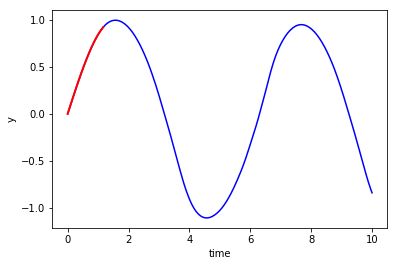

In [33]:
plt.plot(ts_data.x_data, training_data[:len(ts_data.x_data)], 'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_data[:num_time_steps], 'r', linewidth=2)
plt.xlabel('time')
plt.ylabel('y');